# Preliminary Analysis

In this notebook we:
- load CSV file into pandas
- perform basic EDA using Matplotlib to start understanding the data. 

First, we import some of the functions from previous labs:

In [1]:
import neo4j

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

In [2]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

In [3]:
session = driver.session(database="neo4j")

In [4]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

In [5]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

In [6]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")
    

## Data info and Loading

|variable          |class     |description       |
|:-----------------|:---------|:-----------------|
|year              |double    |The year.              |
|coo_name          |character |Country of origin name.        |
|coo               |character |Country of origin UNHCR code.   |
|coo_iso           |character |Country of origin ISO code.  |
|coa_name          |character |Country of asylum name.    |
|coa               |character |Country of asylum UNHCR code.  |
|coa_iso           |character |Country of asylum ISO code.    |
|refugees          |double    |The number of refugees.   |
|asylum_seekers    |double    |The number of asylum-seekers.  |
|returned_refugees |double    |The number of returned refugees. |
|idps              |double    |The number of internally displaced persons.     |
|returned_idps     |double    |The number of returned internally displaced persons.  |
|stateless         |double    |The number of stateless persons.  |
|ooc               |double    |The number of others of concern to UNHCR.   |
|oip               |double    |The number of other people in need of international protection.     |
|hst               |double    |The number of host community members.     |

In [7]:
def create_graph(year, refugee_min=1):
    """
    Loads CSV file for a specific year (files named populationXXXX.csv).
    refugee_min = lower limit of refugees to include (default 1)
    """
    my_neo4j_wipe_out_database()

    query = f"""
        LOAD CSV WITH HEADERS FROM 'file:///population{year}.csv' AS row
        MERGE (origin:Country {{iso_code: row.coo_iso, name: row.coo_name}})
        MERGE (asylum:Country {{iso_code: row.coa_iso, name: row.coa_name}})

        WITH row, origin, asylum
        WHERE toInteger(row.refugees) >= {refugee_min}
        CREATE (origin)-[:REFUGEE_FLOW {{
            year: toInteger(row.year),
            refugees: toInteger(row.refugees),
            asylum_seekers: toInteger(row.asylum_seekers),
            idps: toInteger(row.idps)
        }}]->(asylum)
        """

    session.run(query)

## Understanding Our Data

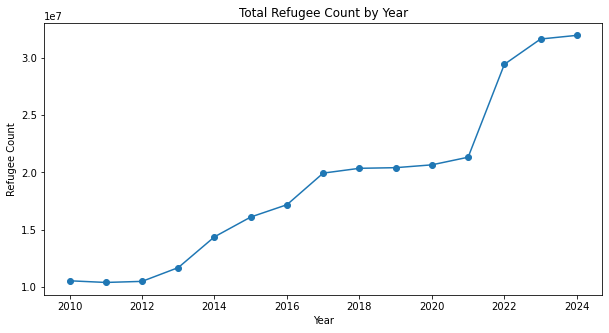

In [9]:
df = pd.read_csv("data/population.csv")
refugee_count = df.groupby('year')['refugees'].sum().reset_index()
refugee_count = refugee_count.sort_values('year', ascending=False)
plt.figure(figsize=(10,5))

plt.plot(refugee_count['year'], refugee_count['refugees'],
        marker = 'o')
plt.title('Total Refugee Count by Year')
plt.xlabel('Year')
plt.ylabel('Refugee Count')
plt.show()

From 2010-2024, refugee number has increased throughout the years according to this dataset. It could mean that from there may more political causes or tension to increase the amount of refugees migrating from one country to another, however, it could also mean that tracking was not as accurate in the earlier years.

<Figure size 720x360 with 0 Axes>

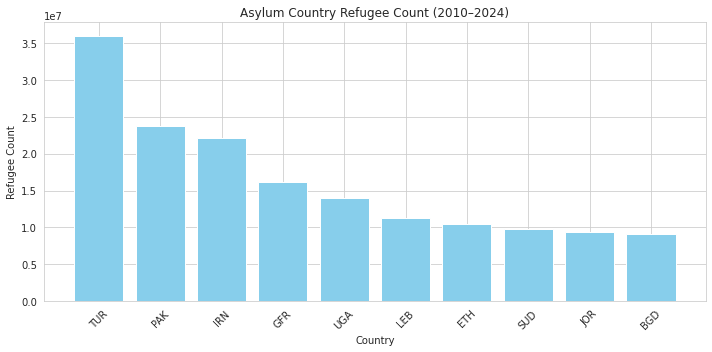

In [32]:
df = pd.read_csv("data/population.csv")

refugee_count = df.groupby('coa')['refugees'].sum().reset_index()
refugee_count = refugee_count.sort_values('refugees', ascending=False)
plt.figure(figsize=(10,5))

plt.figure(figsize=(10, 5))
plt.bar(refugee_count['coa'].head(10), refugee_count['refugees'].head(10), color='skyblue')
plt.title('Asylum Country Refugee Count (2010–2024)')
plt.xlabel('Country')
plt.ylabel('Refugee Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

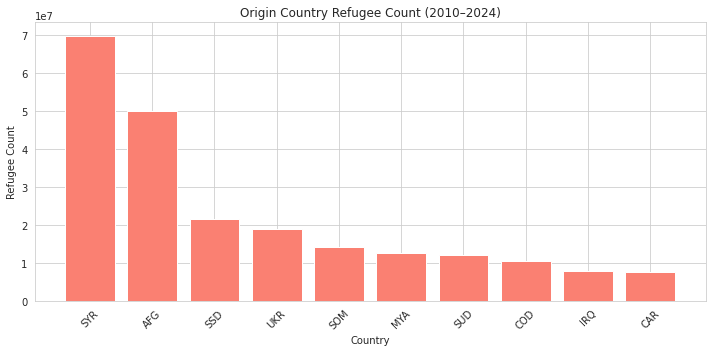

In [34]:
df = pd.read_csv("data/population.csv")

refugee_count = df.groupby('coo')['refugees'].sum().reset_index()
refugee_count = refugee_count.sort_values('refugees', ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(refugee_count['coo'].head(10), refugee_count['refugees'].head(10), color='salmon')
plt.title('Origin Country Refugee Count (2010–2024)')
plt.xlabel('Country')
plt.ylabel('Refugee Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

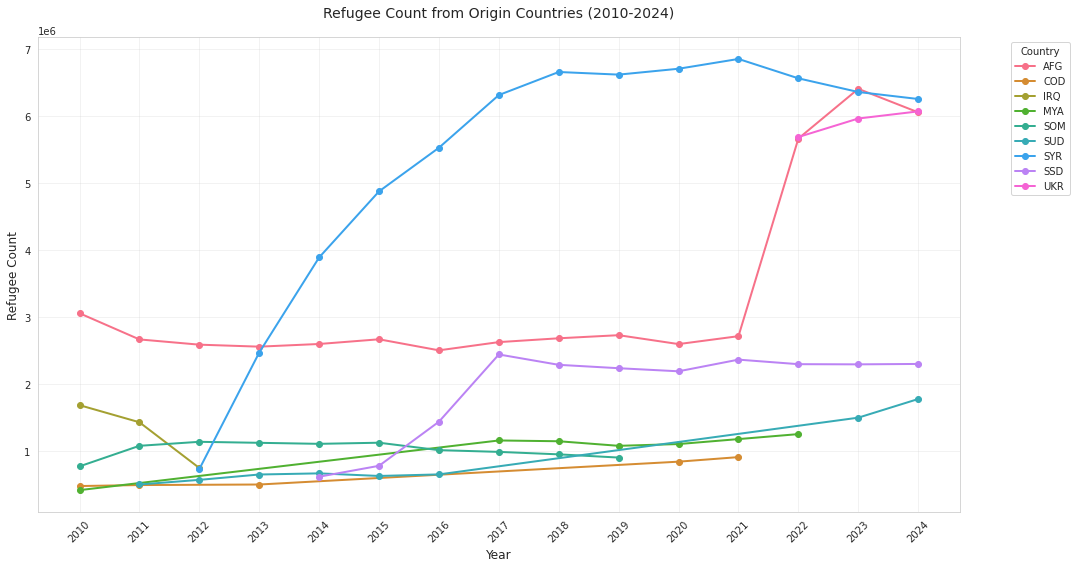

In [12]:
##REFUGEE COUNT PER YEAR FROM ORIGIN COUNTRY 


df = pd.read_csv("data/population.csv")

yearly_top_countries = df.groupby('year').apply(
    lambda x: x.groupby('coo')['refugees'].sum().nlargest(5).index.tolist()
)

filtered_data = pd.concat([
    df[(df['year'] == year) & (df['coo'].isin(countries))]
    for year, countries in yearly_top_countries.items()
])

yearly_country_totals = filtered_data.groupby(['year', 'coo'])['refugees'].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

unique_countries = yearly_country_totals['coo'].unique()
palette = sns.color_palette('husl', n_colors=len(unique_countries))

for i, country in enumerate(unique_countries):
    country_data = yearly_country_totals[yearly_country_totals['coo'] == country]
    plt.plot(country_data['year'], 
             country_data['refugees'],
             marker='o',
             label=country,
             color=palette[i],
             linewidth=2)

plt.title('Refugee Count from Origin Countries (2010-2024)', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Refugee Count', fontsize=12)
plt.xticks(range(2010, 2025), rotation=45)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

from 2010-2013, AFG was the top origin country for refugees. From 2014-2022, SYR became the top origin country for refugees. In 2023 it flipped back to AFG and 2024 back to SYR. The question this sparks is WHY the switch from AFG to SYR in 2014 and why AFG in 2023.

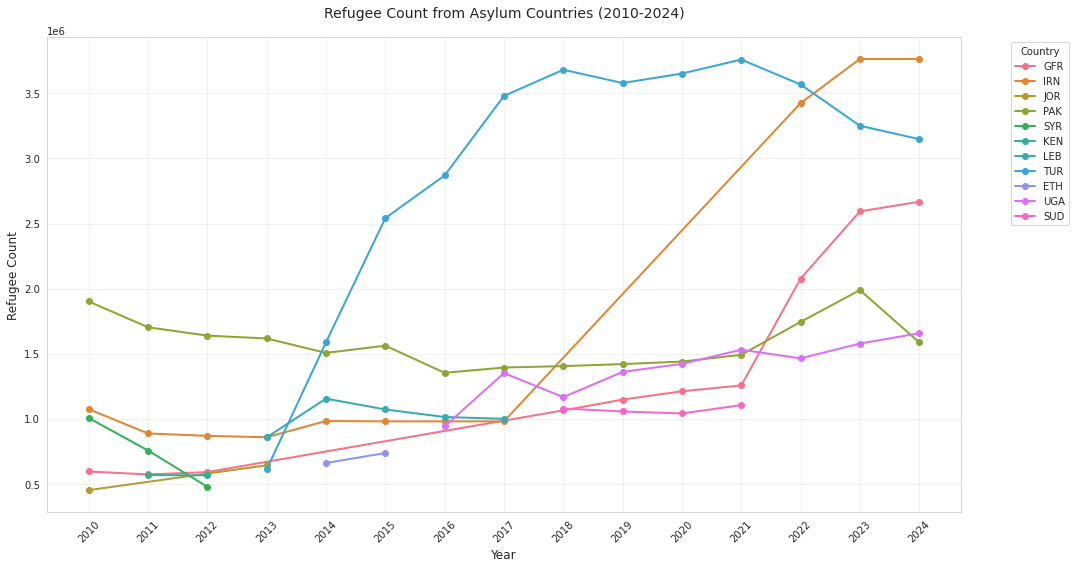

In [13]:
df = pd.read_csv("data/population.csv")

yearly_top_countries = df.groupby('year').apply(
    lambda x: x.groupby('coa')['refugees'].sum().nlargest(5).index.tolist()
)

filtered_data = pd.concat([
    df[(df['year'] == year) & (df['coa'].isin(countries))]
    for year, countries in yearly_top_countries.items()
])

yearly_country_totals = filtered_data.groupby(['year', 'coa'])['refugees'].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

unique_countries = yearly_country_totals['coa'].unique()
palette = sns.color_palette('husl', n_colors=len(unique_countries))

for i, country in enumerate(unique_countries):
    country_data = yearly_country_totals[yearly_country_totals['coa'] == country]
    plt.plot(country_data['year'], 
             country_data['refugees'],
             marker='o',
             label=country,
             color=palette[i],
             linewidth=2)

plt.title('Refugee Count from Asylum Countries (2010-2024)', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Refugee Count', fontsize=12)
plt.xticks(range(2010, 2025), rotation=45)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

From 2010-2013 PAK was the highest asylum country. 2014-2022 TUR became the highest asylum country. 2023-2024 IRN becomes the highest asylum country. This sparks the question why did it switch from PAK to TUR in 2013 and why did IRN become the highest in 2023.

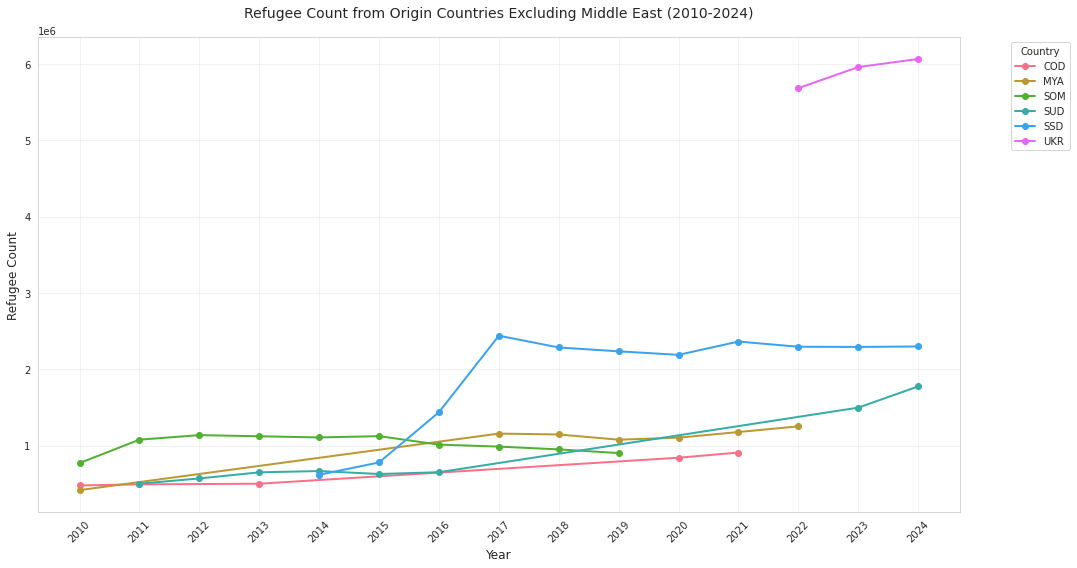

In [20]:
##REFUGEE COUNT PER YEAR EXCLUDING MIDDLE EAST

df = pd.read_csv("data/population.csv")

filtered_data = pd.concat([
    df[(df['year'] == year) & (df['coo'].isin(countries))]
    for year, countries in yearly_top_countries.items()
])

middle_east_countries = ['ARE', 'BHR', 'IRQ', 'IRN', 'ISR', 'JOR', 'KWT', 'LBN', 
                        'OMN', 'PSE', 'QAT', 'SAU', 'SYR', 'TUR', 'YEM', 'AFG', 'CYP', 'EGY']

df_filtered = filtered_data[~filtered_data['coo'].isin(middle_east_countries)]



df_agg = df_filtered.groupby(['year', 'coo'])['refugees'].sum().reset_index()



yearly_top_countries = df.groupby('year').apply(
    lambda x: x.groupby('coo')['refugees'].sum().nlargest(5).index.tolist()
)


yearly_country_totals = df_filtered.groupby(['year', 'coo'])['refugees'].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

unique_countries = yearly_country_totals['coo'].unique()
palette = sns.color_palette('husl', n_colors=len(unique_countries))

for i, country in enumerate(unique_countries):
    country_data = yearly_country_totals[yearly_country_totals['coo'] == country]
    plt.plot(country_data['year'], 
             country_data['refugees'],
             marker='o',
             label=country,
             color=palette[i],
             linewidth=2)

plt.title('Refugee Count from Origin Countries Excluding Middle East (2010-2024)', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Refugee Count', fontsize=12)
plt.xticks(range(2010, 2025), rotation=45)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

The middle east has had political tension from 2010-2024, so it's important to see what else in the world is going on. This graph shows the refugee origin countries excluding the middle east. SOM has greatest count from 2010-2015, SSD from 2016-2021, and UKR from 2022-2024. This helps us explore more of what is happening in SOM, SSD, and UKR.

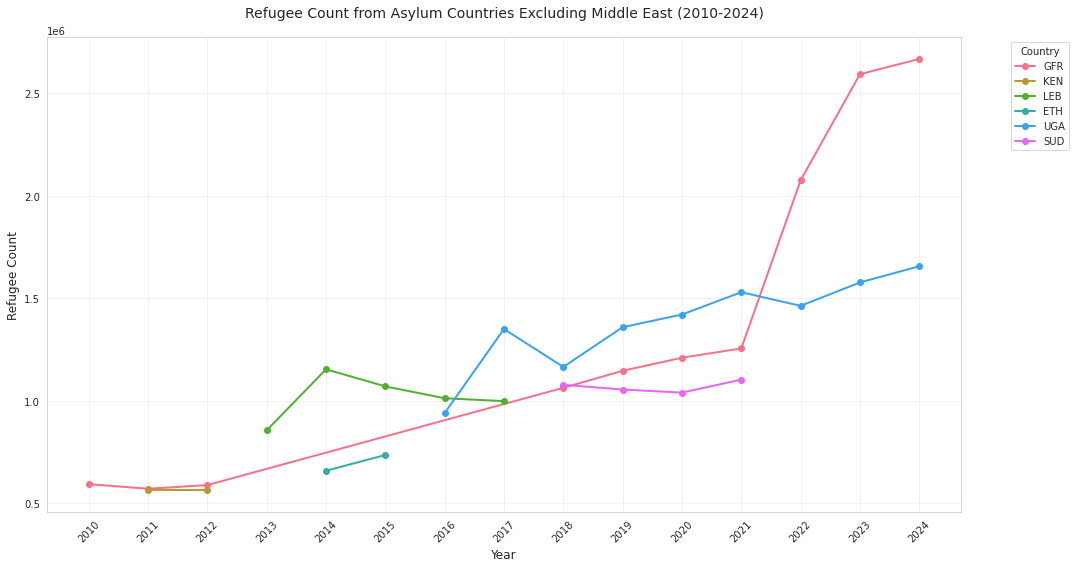

In [21]:
##ASYLUM REFUGEE COUNT PER YEAR EXCLUDING MIDDLE EAST


df_agg = df_filtered.groupby(['year', 'coa'])['refugees'].sum().reset_index()

df = pd.read_csv("data/population.csv")

yearly_top_countries = df.groupby('year').apply(
    lambda x: x.groupby('coa')['refugees'].sum().nlargest(5).index.tolist()
)

filtered_data = pd.concat([
    df[(df['year'] == year) & (df['coa'].isin(countries))]
    for year, countries in yearly_top_countries.items()
])

middle_east_countries = ['ARE', 'BHR', 'IRQ', 'IRN', 'ISR', 'JOR', 'KWT', 'LBN', 
                        'OMN', 'PSE', 'QAT', 'SAU', 'SYR', 'TUR', 'YEM', 'AFG', 'CYP', 'EGY', 'PAK']

df_filtered = filtered_data[~filtered_data['coa'].isin(middle_east_countries)]


yearly_country_totals = df_filtered.groupby(['year', 'coa'])['refugees'].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

unique_countries = yearly_country_totals['coa'].unique()
palette = sns.color_palette('husl', n_colors=len(unique_countries))

for i, country in enumerate(unique_countries):
    country_data = yearly_country_totals[yearly_country_totals['coa'] == country]
    plt.plot(country_data['year'], 
             country_data['refugees'],
             marker='o',
             label=country,
             color=palette[i],
             linewidth=2)

plt.title('Refugee Count from Asylum Countries Excluding Middle East (2010-2024)', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Refugee Count', fontsize=12)
plt.xticks(range(2010, 2025), rotation=45)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Similarly to the last one, the asylum countries are listed without regards to the middle eastern political tension. GFR is top asylum country from 2010-2013, LEB from 2013-2016 and UGA from 2017-2021. Then GFR takes top asylum countries again in 2022-2024.

It's interesting to note here, that although America is defined as a "melting pot" and according to the PageRank, it is true in that it takes refugees from around the world. The amount of refugees is a lot lower than other countries. 

**Note: we explain and use the PageRank function in much more depth in the data_science_graph_algos notebook.**

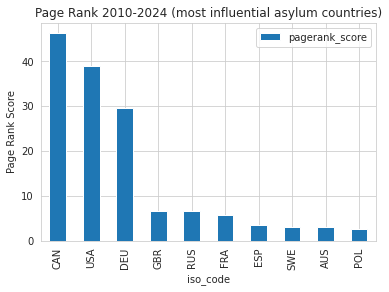

In [86]:
def analyze_refugee_pagerank(year, refugee_min=1, direction='natural', 
                             damping=0.85, maxIterations=100):
    """
    Analyze refugee flow with pagerank for a specific year with configurable direction
    Parameters:
    - year: Dataset year to analyze
    - refugee_min: Minimum refugee count to include (default 1)
    - direction: 'natural' (origin->asylum) or 'reverse' (asylum->origin)
    - 
    Returns pandas dataframe w/ pagerank results
    """
    create_graph(year, refugee_min=refugee_min)
    session.run("CALL gds.graph.drop('pagerank_graph', false) YIELD graphName")
    
    # Project graph with specified direction
    orientation = 'NATURAL' if direction.lower() == 'natural' else 'REVERSE'
    project_query = f"""
    CALL gds.graph.project(
        'pagerank_graph',
        'Country',
        {{REFUGEE_FLOW: {{
            orientation: '{orientation}',
            properties: 'refugees'
        }}}}
    )
    """
    session.run(project_query)
    
    #pagerank w/ refugee counts as weights
    pagerank_query = f"""
    CALL gds.pageRank.stream('pagerank_graph', {{
        maxIterations: {maxIterations},
        dampingFactor: {damping},
        relationshipWeightProperty: 'refugees'
    }})
    YIELD nodeId, score
    RETURN 
        gds.util.asNode(nodeId).name AS country,
        gds.util.asNode(nodeId).iso_code as iso_code,
        score AS pagerank_score
    ORDER BY pagerank_score DESC
    """
    return my_neo4j_run_query_pandas(pagerank_query)


df = analyze_refugee_pagerank('all', direction='natural')
df[:10].plot.bar(x='iso_code', y='pagerank_score')
plt.ylabel("Page Rank Score")
plt.title("Page Rank 2010-2024 (most influential asylum countries)")
plt.show()

### Refugee Count by Year

Below we create graphs to analyze the countries that receive/send the most refugees by year. 

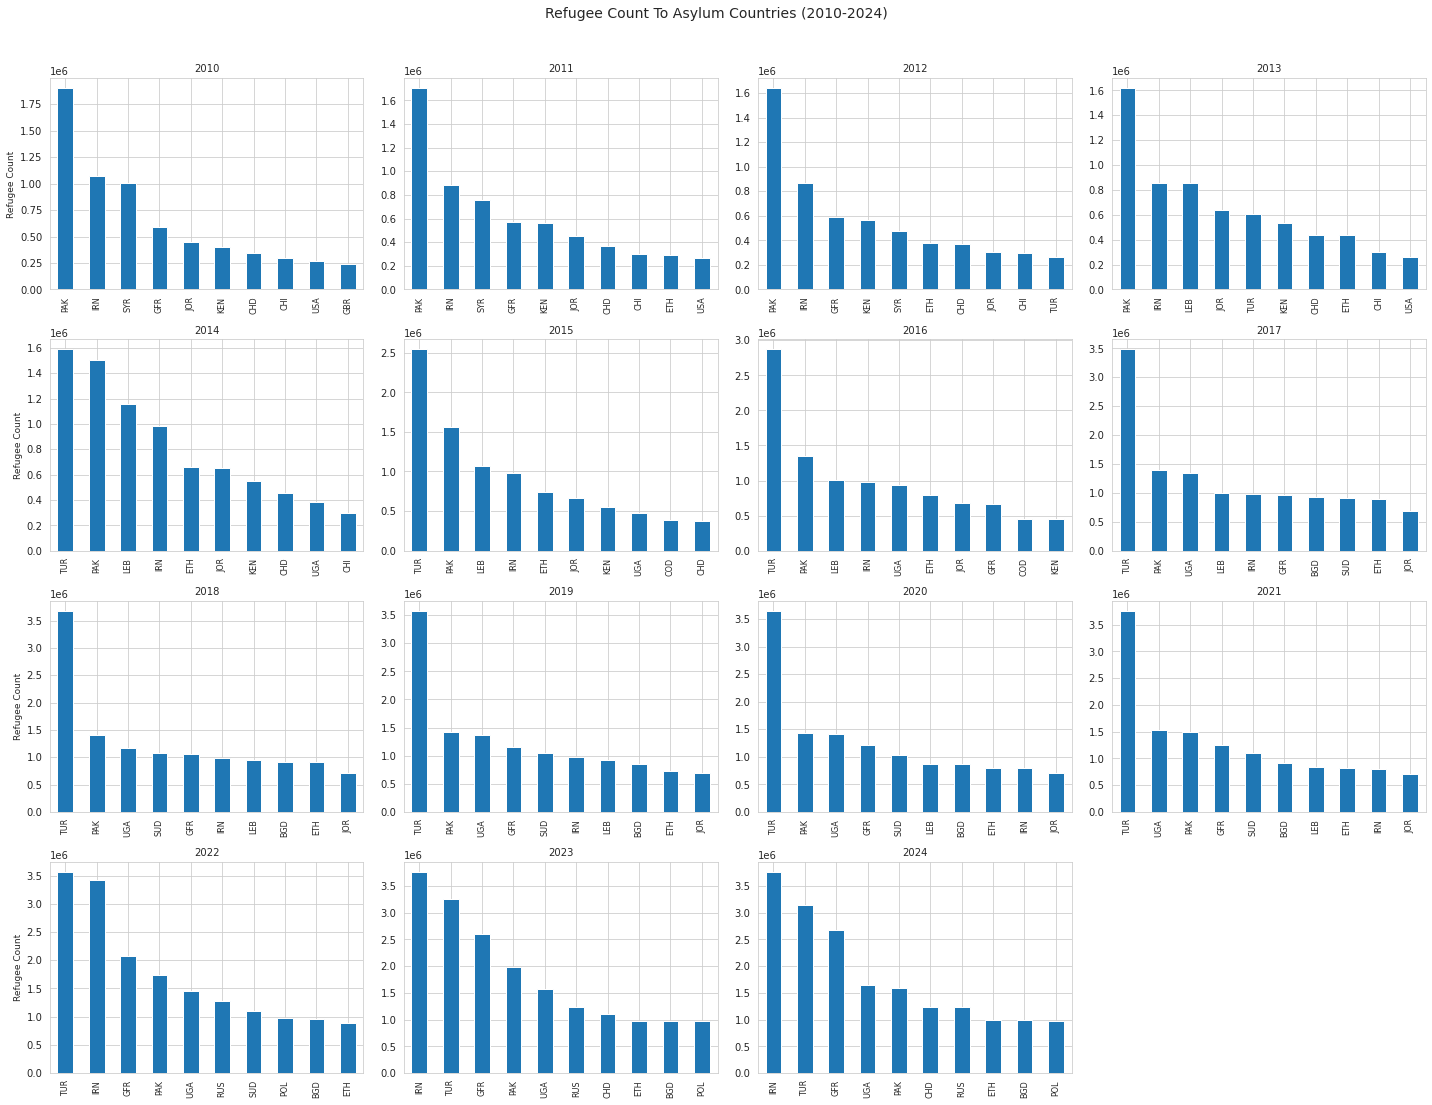

In [22]:
## REFUGEE COUNT PER YEAR TO ASLYLUM COUNTRY

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
fig.suptitle('Refugee Count To Asylum Countries (2010-2024)', y=1.02, fontsize=14)
plt.subplots_adjust(hspace=0.5, wspace=0.3)

df = pd.read_csv("data/population.csv")

axes= axes.flatten()

for idx, year in enumerate(range(2010, 2025)):

    ax = axes[idx]

    df_year= df[df['year']==year]
    df2= df_year.groupby('coa')['refugees'].sum().reset_index()
    df2=df2.sort_values('refugees',ascending=False)

    top_10=df2.head(10)
    top_10.plot.bar(x='coa', y='refugees', ax=ax, legend=False)


    ax.set_title(f'{year}', fontsize=10)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.set_xlabel('')

    if idx % 4 == 0:
        ax.set_ylabel("Refugee Count", fontsize=9)   

for idx in range(len(range(2010, 2025)), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

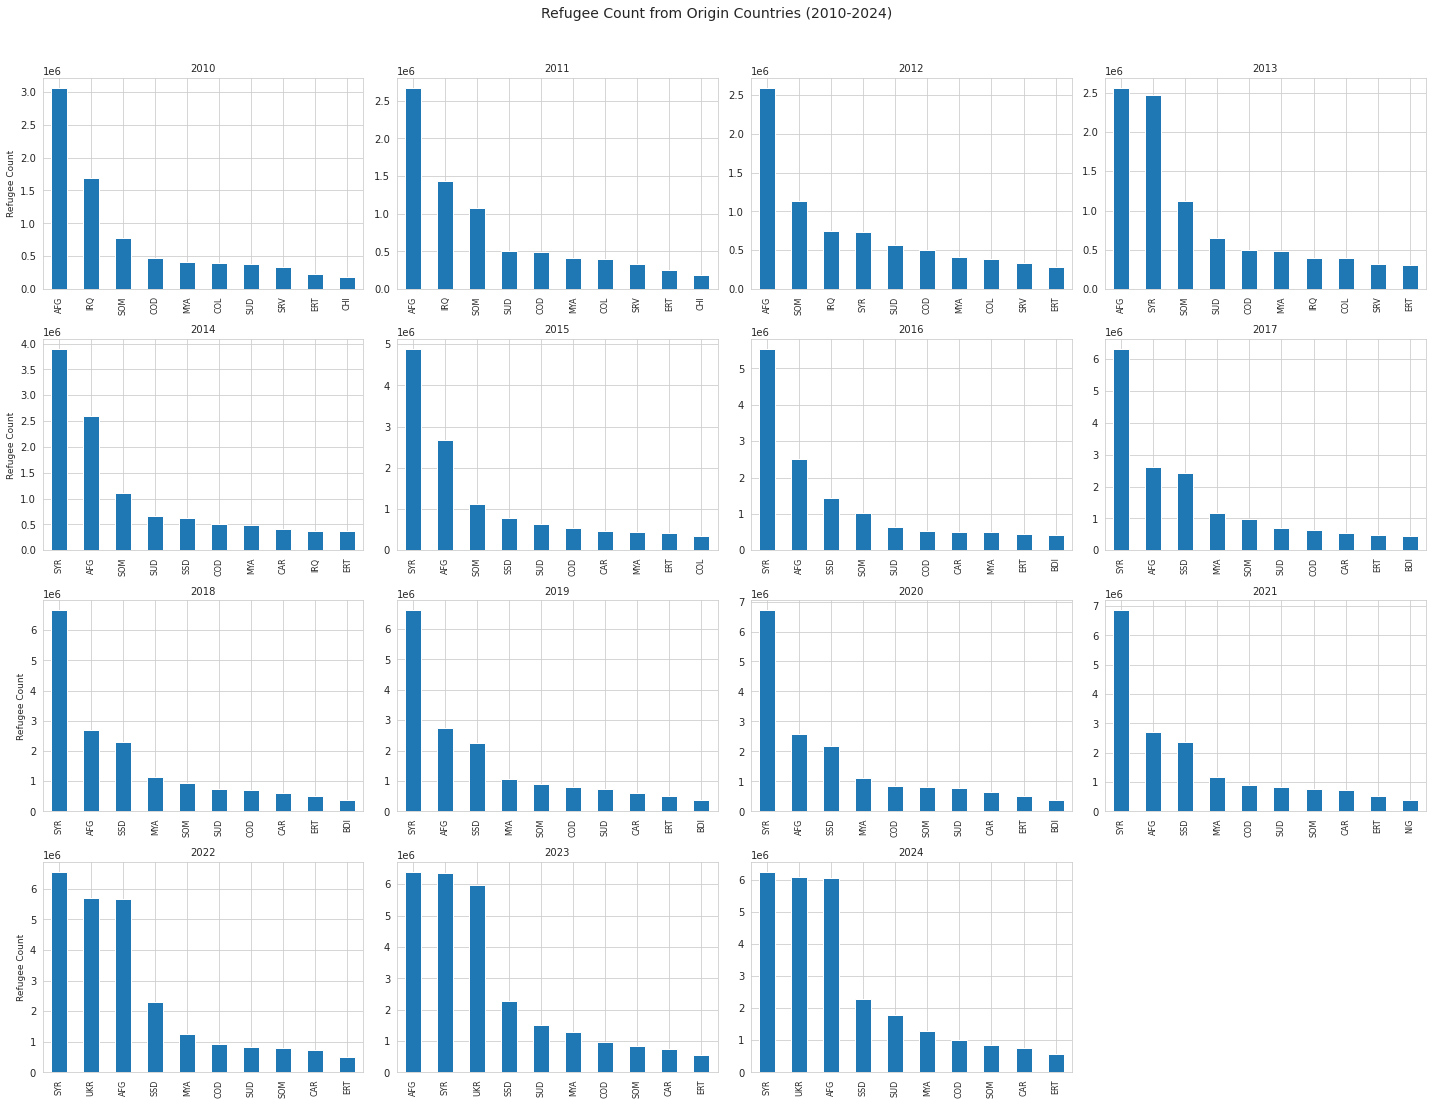

In [23]:
##REFUGEE COUNT PER YEAR FROM ORIGIN COUNTRY 

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
fig.suptitle('Refugee Count from Origin Countries (2010-2024)', y=1.02, fontsize=14)
plt.subplots_adjust(hspace=0.5, wspace=0.3)

df = pd.read_csv("data/population.csv")

axes= axes.flatten()

for idx, year in enumerate(range(2010, 2025)):

    ax = axes[idx]

    df_year= df[df['year']==year]
    df2= df_year.groupby('coo')['refugees'].sum().reset_index()
    df2=df2.sort_values('refugees',ascending=False)

    top_10=df2.head(10)
    top_10.plot.bar(x='coo', y='refugees', ax=ax, legend=False)


    ax.set_title(f'{year}', fontsize=10)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.set_xlabel('')

    if idx % 4 == 0:
        ax.set_ylabel("Refugee Count", fontsize=9)   

for idx in range(len(range(2010, 2025)), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

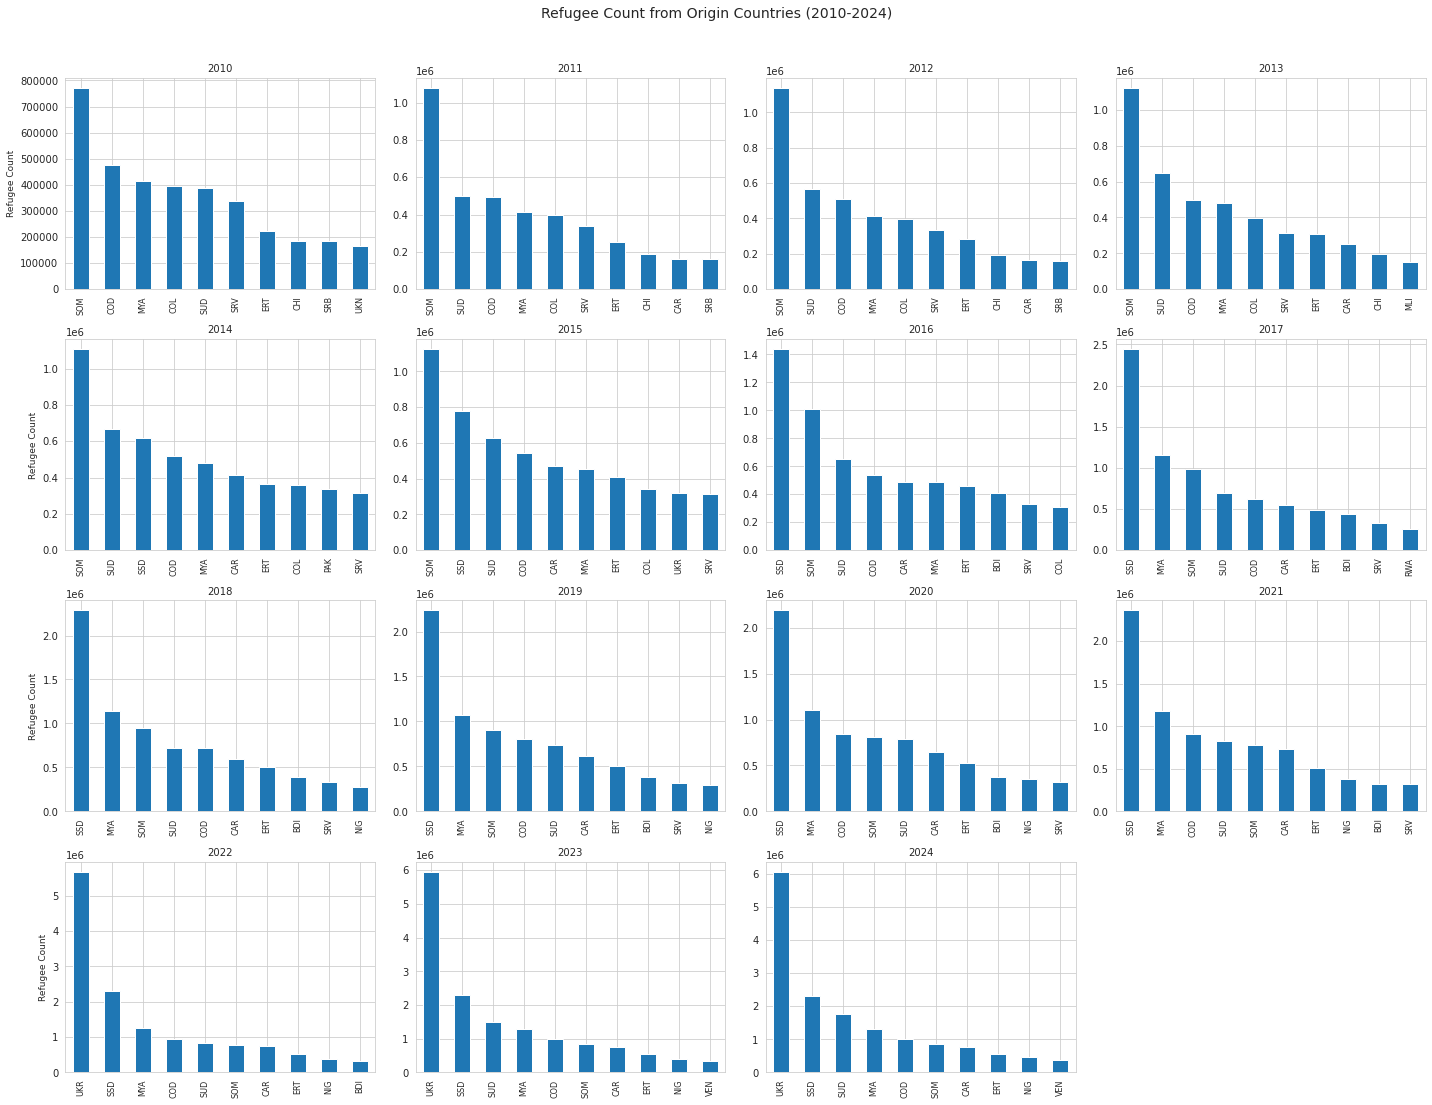

In [24]:
##REFUGEE COUNT PER YEAR FROM ORIGIN COUNTRY EXC MIDDLE EAST

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
fig.suptitle('Refugee Count from Origin Countries (2010-2024)', y=1.02, fontsize=14)
plt.subplots_adjust(hspace=0.5, wspace=0.3)

df = pd.read_csv("data/population.csv")
middle_east_countries= ['ARE','BHR','IRQ','IRN','ISR','JOR','KWT','LBN', 
    'OMN','PSE','QAT','SAU','SYR','TUR','YEM','AFG','CYP','EGY']
df_filtered = df[~df['coo'].isin(middle_east_countries)]
axes= axes.flatten()

for idx, year in enumerate(range(2010, 2025)):

    ax = axes[idx]

    df_year= df_filtered[df_filtered['year']==year]
    df2= df_year.groupby('coo')['refugees'].sum().reset_index()
    df2=df2.sort_values('refugees',ascending=False)

    top_10=df2.head(10)
    top_10.plot.bar(x='coo', y='refugees', ax=ax, legend=False)


    ax.set_title(f'{year}', fontsize=10)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.set_xlabel('')

    if idx % 4 == 0:
        ax.set_ylabel("Refugee Count", fontsize=9)   

for idx in range(len(range(2010, 2025)), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


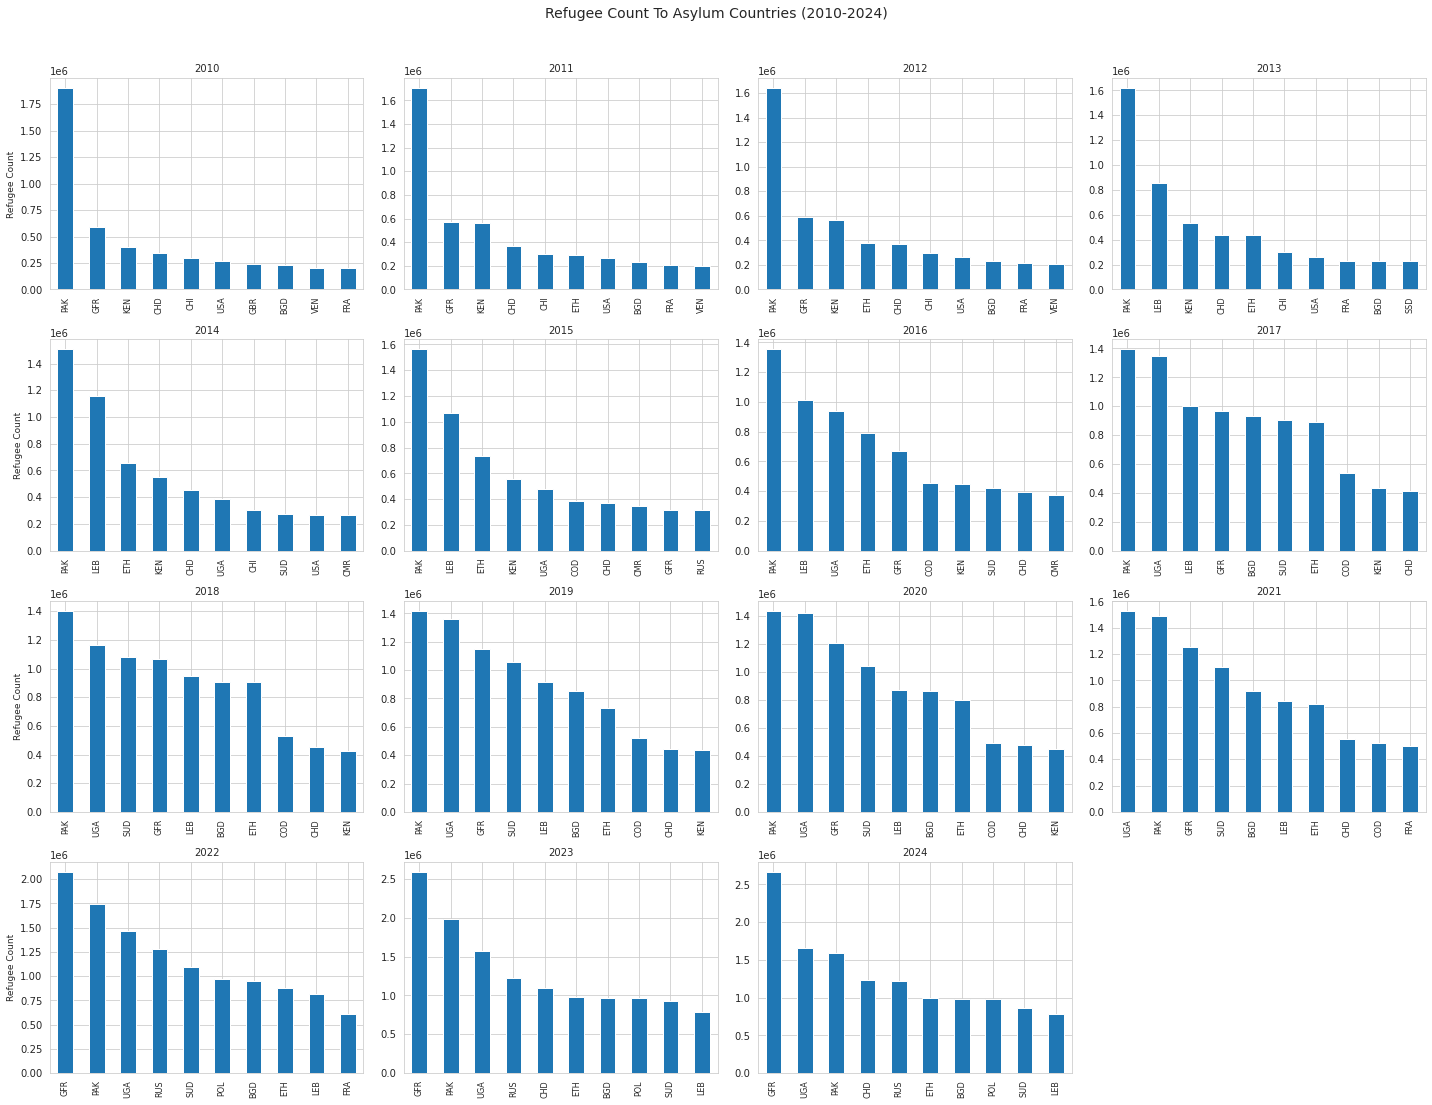

In [25]:
## REFUGEE COUNT PER YEAR TO ASLYLUM COUNTRY EXCLUDING MIDDLE EAST

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
fig.suptitle('Refugee Count To Asylum Countries (2010-2024)', y=1.02, fontsize=14)
plt.subplots_adjust(hspace=0.5, wspace=0.3)

df = pd.read_csv("data/population.csv")
middle_east_countries= ['ARE','BHR','IRQ','IRN','ISR','JOR','KWT','LBN', 
    'OMN','PSE','QAT','SAU','SYR','TUR','YEM','AFG','CYP','EGY']
df_filtered = df[~df['coa'].isin(middle_east_countries)]
axes= axes.flatten()

for idx, year in enumerate(range(2010, 2025)):

    ax = axes[idx]

    df_year= df_filtered[df_filtered['year']==year]
    df2= df_year.groupby('coa')['refugees'].sum().reset_index()
    df2=df2.sort_values('refugees',ascending=False)

    top_10=df2.head(10)
    top_10.plot.bar(x='coa', y='refugees', ax=ax, legend=False)


    ax.set_title(f'{year}', fontsize=10)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.set_xlabel('')

    if idx % 4 == 0:
        ax.set_ylabel("Refugee Count", fontsize=9)   

for idx in range(len(range(2010, 2025)), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()